In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from pathlib import Path
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askdirectory
import csv
import os
import scipy
import glob
import scipy.integrate as integrate
# %matplotlib inline
%matplotlib widget

def displayall ( file_extension):   
    root = Tk()
    root.wm_attributes('-topmost', True)
    path = filedialog.askdirectory()
    root.withdraw()
    return path


In [46]:
spherecorr = pd.read_csv('C:\\Users\\Manvydas\\Desktop\\Qy_Calculator\\corrections\\Z_Edinburg2019Stepono.dat', delimiter='\t', index_col=None, header=0)
spherecorr.columns = ['WL', 'corr']
path = displayall('txp')
used = set()
df = pd.DataFrame()
names = os.listdir(path)
namesspectra = [x for x in names if 'S_' in x]  
print(len(namesspectra), namesspectra)


1 ['S_TIPS-Perylene_PdTpBp_exp50ms_avg100x_@640nm.txp']


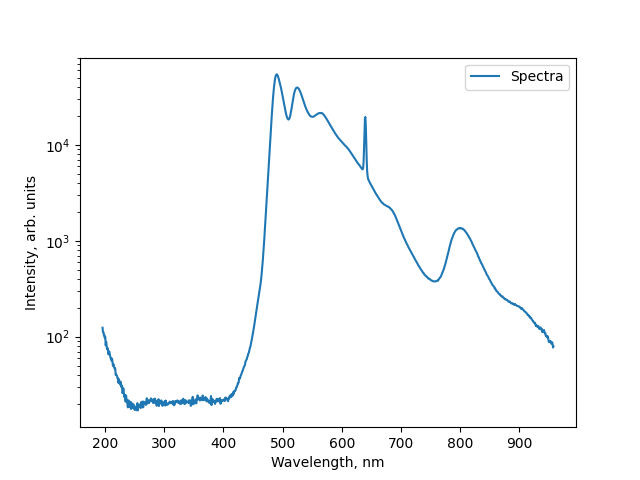

In [47]:
f = 0
plt.close()
df['WL'] = pd.read_csv(path + '\\' +
                       namesspectra[f], usecols=['@0'], sep='\t')
df['S'] = pd.read_csv(path + '\\' +
                      namesspectra[f], usecols=['0.000000'], sep='\t')
plt.plot(df['WL'], df['S'], label='Spectra')
plt.xlabel('Wavelength, nm'); plt.ylabel('Intensity, arb. units')
plt.yscale('log')
plt.legend()
plt.show()


A_TIPS-Perylene_PdTpBp_exp150ms_avg25x_@640nm.txp
B_TIPS-Perylene_PdTpBp_exp150ms_avg25x_@640nm.txp
C_TIPS-Perylene_PdTpBp_exp150ms_avg25x_@640nm.txp
Sample  S_TIPS-Perylene_PdTpBp_exp50ms_avg100x_@640nm.txp  absorbed  16.5  and has a QY of  131.92  with corr  146.09 QY with Pb 119.19  with corr 131.72


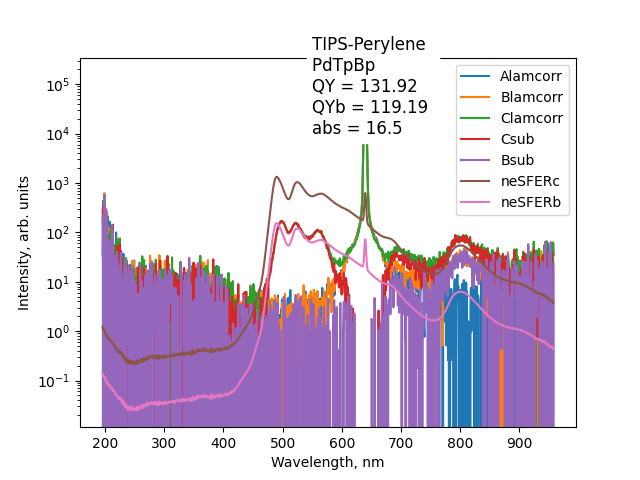

In [57]:
# This cell proccesses data and calculates QY
filter = ''
f = 0
measurement = 'Ch'
comment = '' + measurement
integrate_from_spectra = 428 #350
integrate_to_spectra = 700 #520
integrate_from_laser = 625 #525 
integrate_to_laser = 648 #540

coff = 0.01
coff2 = 1

abscorr = 1.6

df = pd.DataFrame()
if filter:
    filtercorr = pd.read_csv('C:\\Users\\Manvydas\\Desktop\\FTMC\\Projects\\DPA40\\' + filter + ".csv", delimiter=';', index_col=None, header=None)
    filtercorr.columns = ['WL', 'corr']
    df['corr'] = filtercorr['corr'] / spherecorr['corr']
else:
    df['corr'] = 1 / spherecorr['corr']
namecrop = "B_" + namesspectra[f].split('_')[1]# + "_" + namesspectra[f].split('_')[2]
# print(namecrop)
namessph = [x for x in names if namecrop in x]
namessph = namessph[0]


df['WL'] = pd.read_csv(path + '\\' +
                       namesspectra[f], usecols=['@0'], sep='\t')
df['S'] = pd.read_csv(path + '\\' +
                      namesspectra[f], usecols=['0.000000'], sep='\t')
df['A'] = pd.read_csv(path + '\\' +
                      namessph.replace('B_', 'A_'), usecols=['0.000000'], sep='\t')
df['B'] = pd.read_csv(path + '\\' + namessph,
                      usecols=['0.000000'], sep='\t')
# df['C'] = pd.read_csv(path + '\\' + namessph.replace('B_', 'C_'), usecols = ['0.000000'], sep='\t')
df['C'] = pd.read_csv(path + '\\' + namessph.replace('B_', 'C_').replace('C_TIPS', str(measurement) + '_TIPS'), usecols=['0.000000'], sep='\t')
# df['corr'] = df['corr'].fillna(1E-4)
df['Alamcorr'] = df['A'] * df['WL'] / df['corr'] / 200
df['Blamcorr'] = df['B'] * df['WL'] / df['corr'] / 200
df['Clamcorr'] = df['C'] * df['WL'] / df['corr'] / 200
df['Csub'] = df['Clamcorr'] - df['Alamcorr']
df['Bsub'] = df['Blamcorr'] - df['Alamcorr']
df['neSFERc'] = df['S'] * df['WL'] * coff / 200


dfS = df.copy()
dfS = dfS[dfS['WL'] < integrate_to_spectra]
dfS = dfS[dfS['WL'] > integrate_from_spectra]
c = max(dfS['Csub']) / max(dfS['Bsub'])
df['neSFERb'] = (df['S'] * df['WL'] * coff / 200) / c * coff2
dfS = df.copy()
Pc = float(np.trapz(dfS['neSFERc'], x=dfS['WL']))
Pb = float(np.trapz(dfS['neSFERb'], x=dfS['WL']))


plt.close()
plt.yscale('log')
plt.plot(df['WL'], df['Alamcorr'], label='Alamcorr')
plt.plot(df['WL'], df['Blamcorr'], label='Blamcorr')
plt.plot(df['WL'], df['Clamcorr'], label='Clamcorr')
plt.plot(df['WL'], df['Csub'], label='Csub')
plt.plot(df['WL'], df['Bsub'], label='Bsub')
plt.plot(df['WL'], df['neSFERc'], label='neSFERc')
plt.plot(df['WL'], df['neSFERb'], label='neSFERb')
# plt.xlim(integrate_from_spectra, integrate_to_spectra)
# plt.ylim(1E1, 1E5)


dfL = df.copy()
dfL = dfL[dfL['WL'] < integrate_to_laser]
dfL = dfL[dfL['WL'] > integrate_from_laser]
Lc = float(np.trapz(dfL['Clamcorr'], x=dfL['WL']))
Lb = float(np.trapz(dfL['Blamcorr'], x=dfL['WL']))
La = float(np.trapz(dfL['Alamcorr'], x=dfL['WL']))
abs = round(1 - (Lc/Lb), 3)
qy = round(100*(Pc/(La*(abs))), 2)
qy2 = round(100*(Pc/(La*(abs-abscorr/100))), 2)
qy3 = round(100*((Pc-(1-abs)*Pb)/(La*abs)), 2)
qy4 = round(100*((Pc-(1-(abs-abscorr/100))*Pb)/(La*(abs-abscorr/100))), 2)

print(namessph.replace('B_', 'A_'))
print(namessph)
print(namessph.replace('B_', 'C_').replace(
    '_tecoflex', str(measurement) + '_tecoflex'))

print('Sample ', namesspectra[f], ' absorbed ', round(
    abs*100, 2), ' and has a QY of ', qy, ' with corr ', qy2, 'QY with Pb', qy3, ' with corr', qy4)
message = '%s \n%s \nQY = %s \nQYb = %s \nabs = %s'%(namesspectra[f].split('_')[1], namesspectra[f].split('_')[2].replace('.txp',''), qy, qy3, abs*100)
plt.xlabel('Wavelength, nm'); plt.ylabel('Intensity, arb. units')
plt.text(550, 1E4, message, fontsize = 12, backgroundcolor = 'w')
plt.legend()
plt.show()


# THIS SECTION WRITES USER PARAMETERS FILE
now = datetime.datetime.now()
now = now.strftime("%Y/%m/%d %H:%M:%S")
headerList = ['Time', 'Sample', 'comment', 'La', 'Lb', 'Lc', 'Pc', 'Pb', 'abs', 'abscorr', 'qy',
              'qy2', 'qy3', 'qy4', 'P integrate from', 'P integrate to', 'L integrate from', 'Pc integrate to']
parameters_list = [now, namesspectra[f], comment, La, Lb, Lc, Pc, Pb, round(
    abs*100, 2), abscorr, qy, qy2, qy3, qy4, integrate_from_spectra, integrate_to_spectra, integrate_from_laser, integrate_to_laser]
csvname = os.path.join(path + "\\" + 'QY.csv')
if not os.path.exists(csvname):
    with open(csvname, 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=';')
        resultwriter.writerow(headerList)
    with open(csvname, 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=';')
        resultwriter.writerow(parameters_list)
else:
    with open(csvname, 'a', newline='') as csvfile:
        resultwriter = csv.writer(csvfile, delimiter=';')
        resultwriter.writerow(parameters_list)
    # print(df)

    # df = pd.read_csv(pathfullspectra + '\\' + f + namerest, usecols = ['0.000000'], sep='\t')


In [58]:
# This cell exports the dataset used for QY calc above

csvdatname = os.path.join(path + "\\" + namesspectra[f].split('_')[1] + "_" + measurement + "_" + 'spectraldata.csv')
df.replace([np.inf, -np.inf], 0, inplace=True)
df.to_csv(csvdatname)